In [1]:
from   joblib import dump
import numpy as np
import pandas as pd
import random
from   sklearn.ensemble import RandomForestClassifier
from   sklearn.metrics import accuracy_score, roc_auc_score
from   source.feature_importance import extract_feature_importance, plot_feature_importance, rank_feature_importance
from   source.feature_selection import remove_correlated_features
from   source.model_evaluation import adjusted_prediction, eval_sensitivity_specificity

## Settings

In [2]:
# Set feature files (contains patient info and pyradiomics features)
feature_file_training_set = 'data/training_features.csv' # RVC dataset
label_file_training_set   = 'data/training_labels.csv'

# Number of thresholds
n_thresholds = 401

# Feature selection
corr_threshold    = 0.8

# Fix seed
seed = 42
np.random.seed(seed)
random.seed(seed)

## Data

In [3]:
# Load pyradiomics features and labels
df_features_training = pd.read_csv(feature_file_training_set)
labels_training      = np.loadtxt(label_file_training_set)

In [4]:
# Inspect features
df_features_training

,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,...,feature 91,feature 92,feature 93,feature 94,feature 95,feature 96,feature 97,feature 98,feature 99,feature 100
0,0.191681,0.681715,0.756724,0.194280,0.822150,0.199785,0.738778,0.985086,0.374917,0.314246,...,0.518682,0.086374,0.963351,0.194376,0.540675,0.226328,0.304750,0.710070,0.837559,0.802265
1,0.117275,0.875857,0.966398,0.351835,0.304061,0.610628,0.488750,0.931685,0.806157,0.445136,...,0.147781,0.820527,0.816391,0.498862,0.137967,0.774840,0.815698,0.288172,0.039020,0.056555
2,0.920883,0.937361,0.770071,0.423911,0.926546,0.850611,0.839343,0.909356,0.902662,0.852342,...,0.859154,0.516553,0.752651,0.544660,0.360216,0.879797,0.880911,0.050922,0.789385,0.744718
3,0.588140,0.284251,0.674035,0.729705,0.268254,0.520289,0.415368,0.660507,0.668951,0.544255,...,0.900673,0.842319,0.188757,0.467804,0.280204,0.345736,0.725720,0.193215,0.458771,0.497181
4,0.919214,0.209184,0.245116,0.022100,0.820103,0.586720,0.665220,0.359731,0.206106,0.584706,...,0.143223,0.733424,0.447821,0.844970,0.645869,0.898718,0.752862,0.485091,0.980440,0.353727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.168559,0.201989,0.782727,0.027003,0.835797,0.148582,0.009273,0.894985,0.608939,0.396547,...,0.744932,0.586659,0.401729,0.620584,0.316621,0.576131,0.463744,0.015369,0.336376,0.287213
196,0.772102,0.343814,0.975428,0.465960,0.808325,0.881415,0.714263,0.244628,0.288478,0.766744,...,0.005081,0.835137,0.861921,0.561068,0.540907,0.807550,0.530856,0.851136,0.485639,0.644259
197,0.810432,0.094476,0.045015,0.029192,0.335937,0.506159,0.963874,0.407402,0.121867,0.052002,...,0.503330,0.818668,0.293306,0.853262,0.130221,0.600026,0.267106,0.515387,0.434660,0.688509
198,0.349241,0.639312,0.609451,0.940277,0.916994,0.798495,0.386195,0.207267,0.742174,0.107218,...,0.540746,0.030817,0.291170,0.222700,0.521279,0.111949,0.346591,0.454785,0.377762,0.006623


In [5]:
# Inspect labels
labels_training

array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.])

## Feature selection

Of the features previously extracted, features highly correlated with another feature are identified and excluded from the analysis. This feature selection based on pair-wise feature correlation is applied to improve the machine learning training process and to enable optimized feature interpretability. For this purpose, we calculate a Pearson correlation matrix for all features extracted from the training set and exclude one feature of any feature pair with a Person correlation coefficient above 'corr_threshold'.

In [6]:
# Identify and remove strongly correlated features in the training dataset
df_features_training_uncorr, dropped_features = remove_correlated_features(df_features_training, corr_threshold=corr_threshold)

# Save names of features which have been dropped and will not be used for training or evaluating the random forest model
dropped_features = np.asarray(dropped_features)
np.savetxt('feature_selection/dropped_features.csv', dropped_features, newline=',', fmt='%s')

# Save names of features which have been selected and will be used for training and evaluating the random forest model
feature_names = df_features_training_uncorr.columns.to_numpy()
np.savetxt('feature_selection/selected_features.csv', feature_names, newline=',', fmt='%s')
print("Number of remaining features:", len(feature_names))

Remove correlated features...
Correlation threshold: 0.8
Drop 0 / 100  features ( 0.0 %).
Number of remaining features: 100


## Random forest training

In [7]:
# Prepare the training data, i.e. select the feature columns and the label column, respectively, and ignore the rest.
X_train = df_features_training_uncorr.to_numpy()
y_train = labels_training

# Set up the random forest model
rf = RandomForestClassifier(n_estimators=1000, oob_score=True, random_state=0)

# Train the model
rf.fit(X_train, y_train)

# Save model
dump(rf, 'trained_models/trained_random_forest_model.joblib')

['trained_models/trained_random_forest_model.joblib']

## Internal validation (using out-of-bag predictions)

We use the out-of-bag (OOB) predictions to get a point estimate of the performance that can be expected from the model for unseen data. In addition, we evaluate the out-of-bag predictions for a wide range of classification thresholds in order to pick and report three different models (A, B and C) later on (see below).

In [8]:
# Set up a wide range of classification thresholds
thresholds = np.linspace(0.0,1.0,n_thresholds)

In [9]:
# Internal evaluation
oob_bin_acc     = []
oob_sensitivity = []
oob_specificity = []

oob_roc_auc = roc_auc_score(y_train, rf.oob_decision_function_[:, 1])

# Apply different thresholds for classification
for t in thresholds:

    # Adjust out-of-bag prediction for the current threshold
    y_pred_adj = adjusted_prediction(rf.oob_decision_function_, threshold=t, positive_label=1)

    # Out-of-bag prediction scores for the current threshold
    bin_acc_thr = accuracy_score(y_train, y_pred_adj)
    roc_auc_thr = roc_auc_score(y_train, rf.oob_decision_function_[:, 1])
    sensitivity_thr, specificity_thr = eval_sensitivity_specificity(y_train, y_pred_adj)

    oob_bin_acc.append(bin_acc_thr)
    oob_sensitivity.append(sensitivity_thr)
    oob_specificity.append(specificity_thr)

oob_bin_acc     = np.asarray(oob_bin_acc)
oob_sensitivity = np.asarray(oob_sensitivity)
oob_specificity = np.asarray(oob_specificity)

## Search classification thresholds

Sensitivity, and specificity depend on the classification threshold, a parameter which is used to turn predicted class probabilities, i.e. the output of the random forest model (here: rf.oob_decision_function_) for a given input sample, into class predictions (benign versus premalignant).

Here, we search for three different thresholds:
1. A default threshold value of 0.5 (Model A)
2. A threshold value which maximizes Youden's index (J=sensitivity+specificity1) (Model B)
3. A threshold that results in the highest possible specificity while achieving a sensitivity of at least 0.85 (Model C)

In [10]:
# Find default threshold of 0.5
ind_thr_50 = int(len(thresholds)/2.0)

# Find threshold which maximizes Youden's index J
J         = oob_sensitivity + oob_specificity - 1
J_max     = np.amax(J)
ind_J_max = np.argmax(J)
print("Maximum Youden's index J = {:0.2f} found for threshold T = {:0.4f}".format(J_max, thresholds[ind_J_max]))

# Find threshold which yields sensitivity of 0.85
ind_85 = 0
while(oob_sensitivity[ind_85] >= 0.85):
    ind_85 += 1

Maximum Youden's index J = 0.04 found for threshold T = 0.4850


In [11]:
print("Internal out-of-bag (OOB) validation:\n")
print('oob_roc_auc: {:.2f}'.format(oob_roc_auc))

print("\nOOB scores for threshold of {:0.1f} (Model A):\n".format(thresholds[ind_thr_50]))  
print('bin_acc:     {:0.2f}'.format(oob_bin_acc[ind_thr_50]))
print('sensitivity: {:0.2f}'.format(oob_sensitivity[ind_thr_50]))
print('specifity:   {:0.2f}'.format(oob_specificity[ind_thr_50]))

print("\nOOB scores for a maximized Youden's Index (Model B, threshold = {:0.3f}):\n".format(thresholds[ind_J_max]))  
print('bin_acc:     {:0.2f}'.format(oob_bin_acc[ind_J_max]))
print('sensitivity: {:0.2f}'.format(oob_sensitivity[ind_J_max]))
print('specifity:   {:0.2f}'.format(oob_specificity[ind_J_max]))

print("\nOOB scores for a sensitivity of 0.85 (Model C, threshold = {:0.3f}):\n".format(thresholds[ind_85]))  
print('bin_acc:     {:0.2f}'.format(oob_bin_acc[ind_85]))
print('sensitivity: {:0.2f}'.format(oob_sensitivity[ind_85]))
print('specifity:   {:0.2f}'.format(oob_specificity[ind_85]))

Internal out-of-bag (OOB) validation:

oob_roc_auc: 0.47

OOB scores for threshold of 0.5 (Model A):

bin_acc:     0.48
sensitivity: 0.51
specifity:   0.46

OOB scores for a maximized Youden's Index (Model B, threshold = 0.485):

bin_acc:     0.52
sensitivity: 0.63
specifity:   0.41

OOB scores for a sensitivity of 0.85 (Model C, threshold = 0.443):

bin_acc:     0.48
sensitivity: 0.83
specifity:   0.14


## Feature importance

The Scikit-learn random forest implementation provides an internal estimate of feature importance, i.e. how much the class prediction (benign versus premalignant) of a trained model depends on a specific feature relative to all other features. Here, we evaluate the relative importance of the 198 features used for training the random forest.

 1. feature  67: feature 68 (0.022222)
 2. feature  12: feature 13 (0.017986)
 3. feature  72: feature 73 (0.016780)
 4. feature  19: feature 20 (0.015908)
 5. feature  62: feature 63 (0.015708)
 6. feature  59: feature 60 (0.015280)
 7. feature   2: feature 3 (0.013607)
 8. feature  11: feature 12 (0.013544)
 9. feature  49: feature 50 (0.013539)
10. feature  94: feature 95 (0.013394)


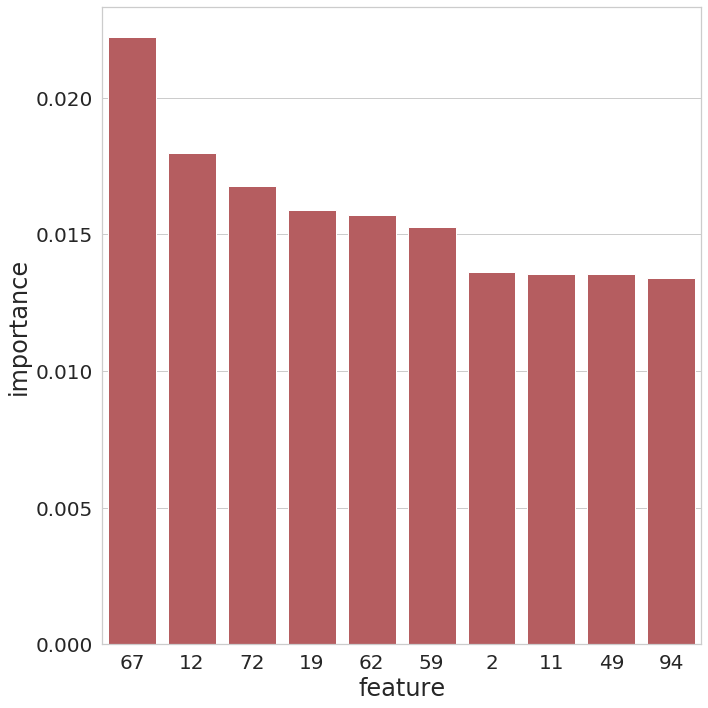

In [12]:
# Get feature importance from random forest model
importances, _ = extract_feature_importance(rf)

# Rank features according to their importance
ranked_features_id, ranked_features_name, ranked_importances = rank_feature_importance(importances, feature_names, n=10)

# Plot feature importance
plot_feature_importance(ranked_features_id, ranked_importances)